# Simulating the Nitrogen-Copper interaction

In this tutorial, we discuss how _covalent_ can be used to manage workflows to simulate the quantum interactions between _Nitrogen_ molecules and a slab of _Copper_. The computations for the quantum interactions are performed using the [Atomic Simulation Environment](https://wiki.fysik.dtu.dk/ase/index.html) (ase) package.

The `covalent` library allows us to **_orchestrate_** and **_execute_** workflows comprised of subtasks. Once, the workflows have been dispatched for execution, we can query the **_status_** of the computations. As the subtasks are completed, the execution results can be **_collected_** using the covalent results manager. The workflow result, which will become available once all the subtasks have finished running, can be **_collected_** in a similar manner. 

First, we import the `covalent` library.

In [1]:
import covalent as ct


Next, we import the tools from the _ase_ package required to perform computations for the quantum interactions. Note that `ase.calculators.emt.EMT` (imported below) is a low compute calculator, which, can be replaced by a high compute calculator and thus making the workflow more computationally expensive.

In [2]:
# !pip install ase
# !pip install ase-notebook
from ase import Atoms
from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.optimize import QuasiNewton
from ase.build import fcc111, add_adsorbate
from ase.io import read
from ase.io.trajectory import Trajectory
from ase_notebook import AseView, ViewConfig
from matplotlib import pyplot as plt


Our objective is to simulate the structural relaxation of the Nitrogen molecules and Copper slabs. The Nitrogen molecules are comprised of two Nitrogen atoms at a distance, $d$, apart. The $\text{N}_{2}$ molecules are placed at a height, $h$, above the copper slab. In order to perform the structural relaxation computation, we fix the distance between the Nitrogen molecules and optimize the height using the quasi-Newtonian algorithm.

Now that we have outlined the purpose of the workflow, we can break it down into smaller subtasks (defined below).

1. `construct_cu_slab` - Construct a copper slab.
2. `compute_system_energy` - Computes the energy of the system in a particular configuration.
3. `construct_n_molecule` - Construct a Nitrogen molecule with some spacing $d$.
4. `get_relaxed_slab` - Get relaxed slab structure where the height is optimized using the quasi-Newtonian method.

The subtasks are constructed below using the [ct.electron](../../api/api.rst#covalent.electron) decorator. 

In [3]:
@ct.electron
def construct_cu_slab(
    unit_cell=(4, 4, 2),
    vacuum=10.0,
):
    slab = fcc111("Cu", size=unit_cell, vacuum=vacuum)
    return slab


@ct.electron
def compute_system_energy(system):
    system.calc = EMT()
    return system.get_potential_energy()


@ct.electron
def construct_n_molecule(d=0):
    return Atoms("2N", positions=[(0.0, 0.0, 0.0), (0.0, 0.0, d)])


@ct.electron
def get_relaxed_slab(slab, molecule, height=1.85):
    slab.calc = EMT()
    add_adsorbate(slab, molecule, height, "ontop")
    constraint = FixAtoms(mask=[a.symbol != "N" for a in slab])
    slab.set_constraint(constraint)
    dyn = QuasiNewton(slab, trajectory="/tmp/N2Cu.traj", logfile="/tmp/temp")
    dyn.run(fmax=0.01)
    return slab


Next, we visualize the problem setup using tools from `ase-notebook`.


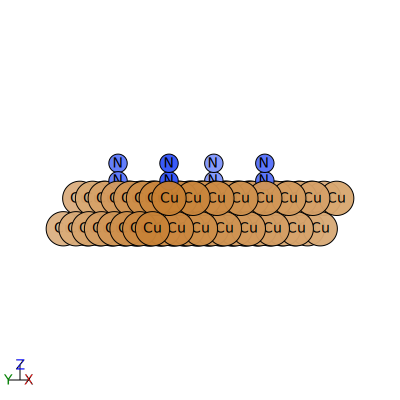

In [4]:
N2 = construct_n_molecule(d=1.2)
slab = construct_cu_slab(unit_cell=(4, 4, 2), vacuum=10.0)
add_adsorbate(slab, N2, 1.2, "ontop")

config = ViewConfig(show_unit_cell=False)
ase_view = AseView(config)
ase_view.config.rotations = "-90x,50y,0z"
config.atom_lighten_by_depth = 0.7
ase_view.make_svg(
    slab,
    center_in_uc=True,
    repeat_uc=(2, 2, 1),
)


Having defined the subtasks, we are now in a position to construct the workflow (`compute_relaxed_structure_energy`) using the [ct.lattice](../../api/api.rst#covalent.lattice) decorator. The structural relaxation is performed by considering the hybridization interaction between Nitrogen and Copper, where, the quasi-Newton method is used to minimize the total kohn-sham energy of the system.

.. tip:: We can specify where the temporary computation results with the `results_dir` parameter in the `ct.lattice` decorator is stored. By default, `results_dir=./results/`.

In [5]:
@ct.lattice
def compute_energy(initial_height=3, distance=1.10):
    N2 = construct_n_molecule(d=distance)
    e_N2 = compute_system_energy(system=N2)

    slab = construct_cu_slab(unit_cell=(4, 4, 2), vacuum=10.0)
    e_slab = compute_system_energy(system=slab)

    relaxed_slab = get_relaxed_slab(slab=slab, molecule=N2, height=initial_height)
    e_relaxed_slab = compute_system_energy(system=relaxed_slab)
    final_result = e_slab + e_N2 - e_relaxed_slab

    return final_result


Once the workflow has been constructed, we can visualize the subtasks and their interdependencies using the built-in `covalent` visualization tool.

In [6]:
compute_energy.draw(initial_height=3, distance=1.10)


One you run the above codeblock, you can check out the ui preview (default at `localhost:48008/preview`) and see the generated graph which will look like this:

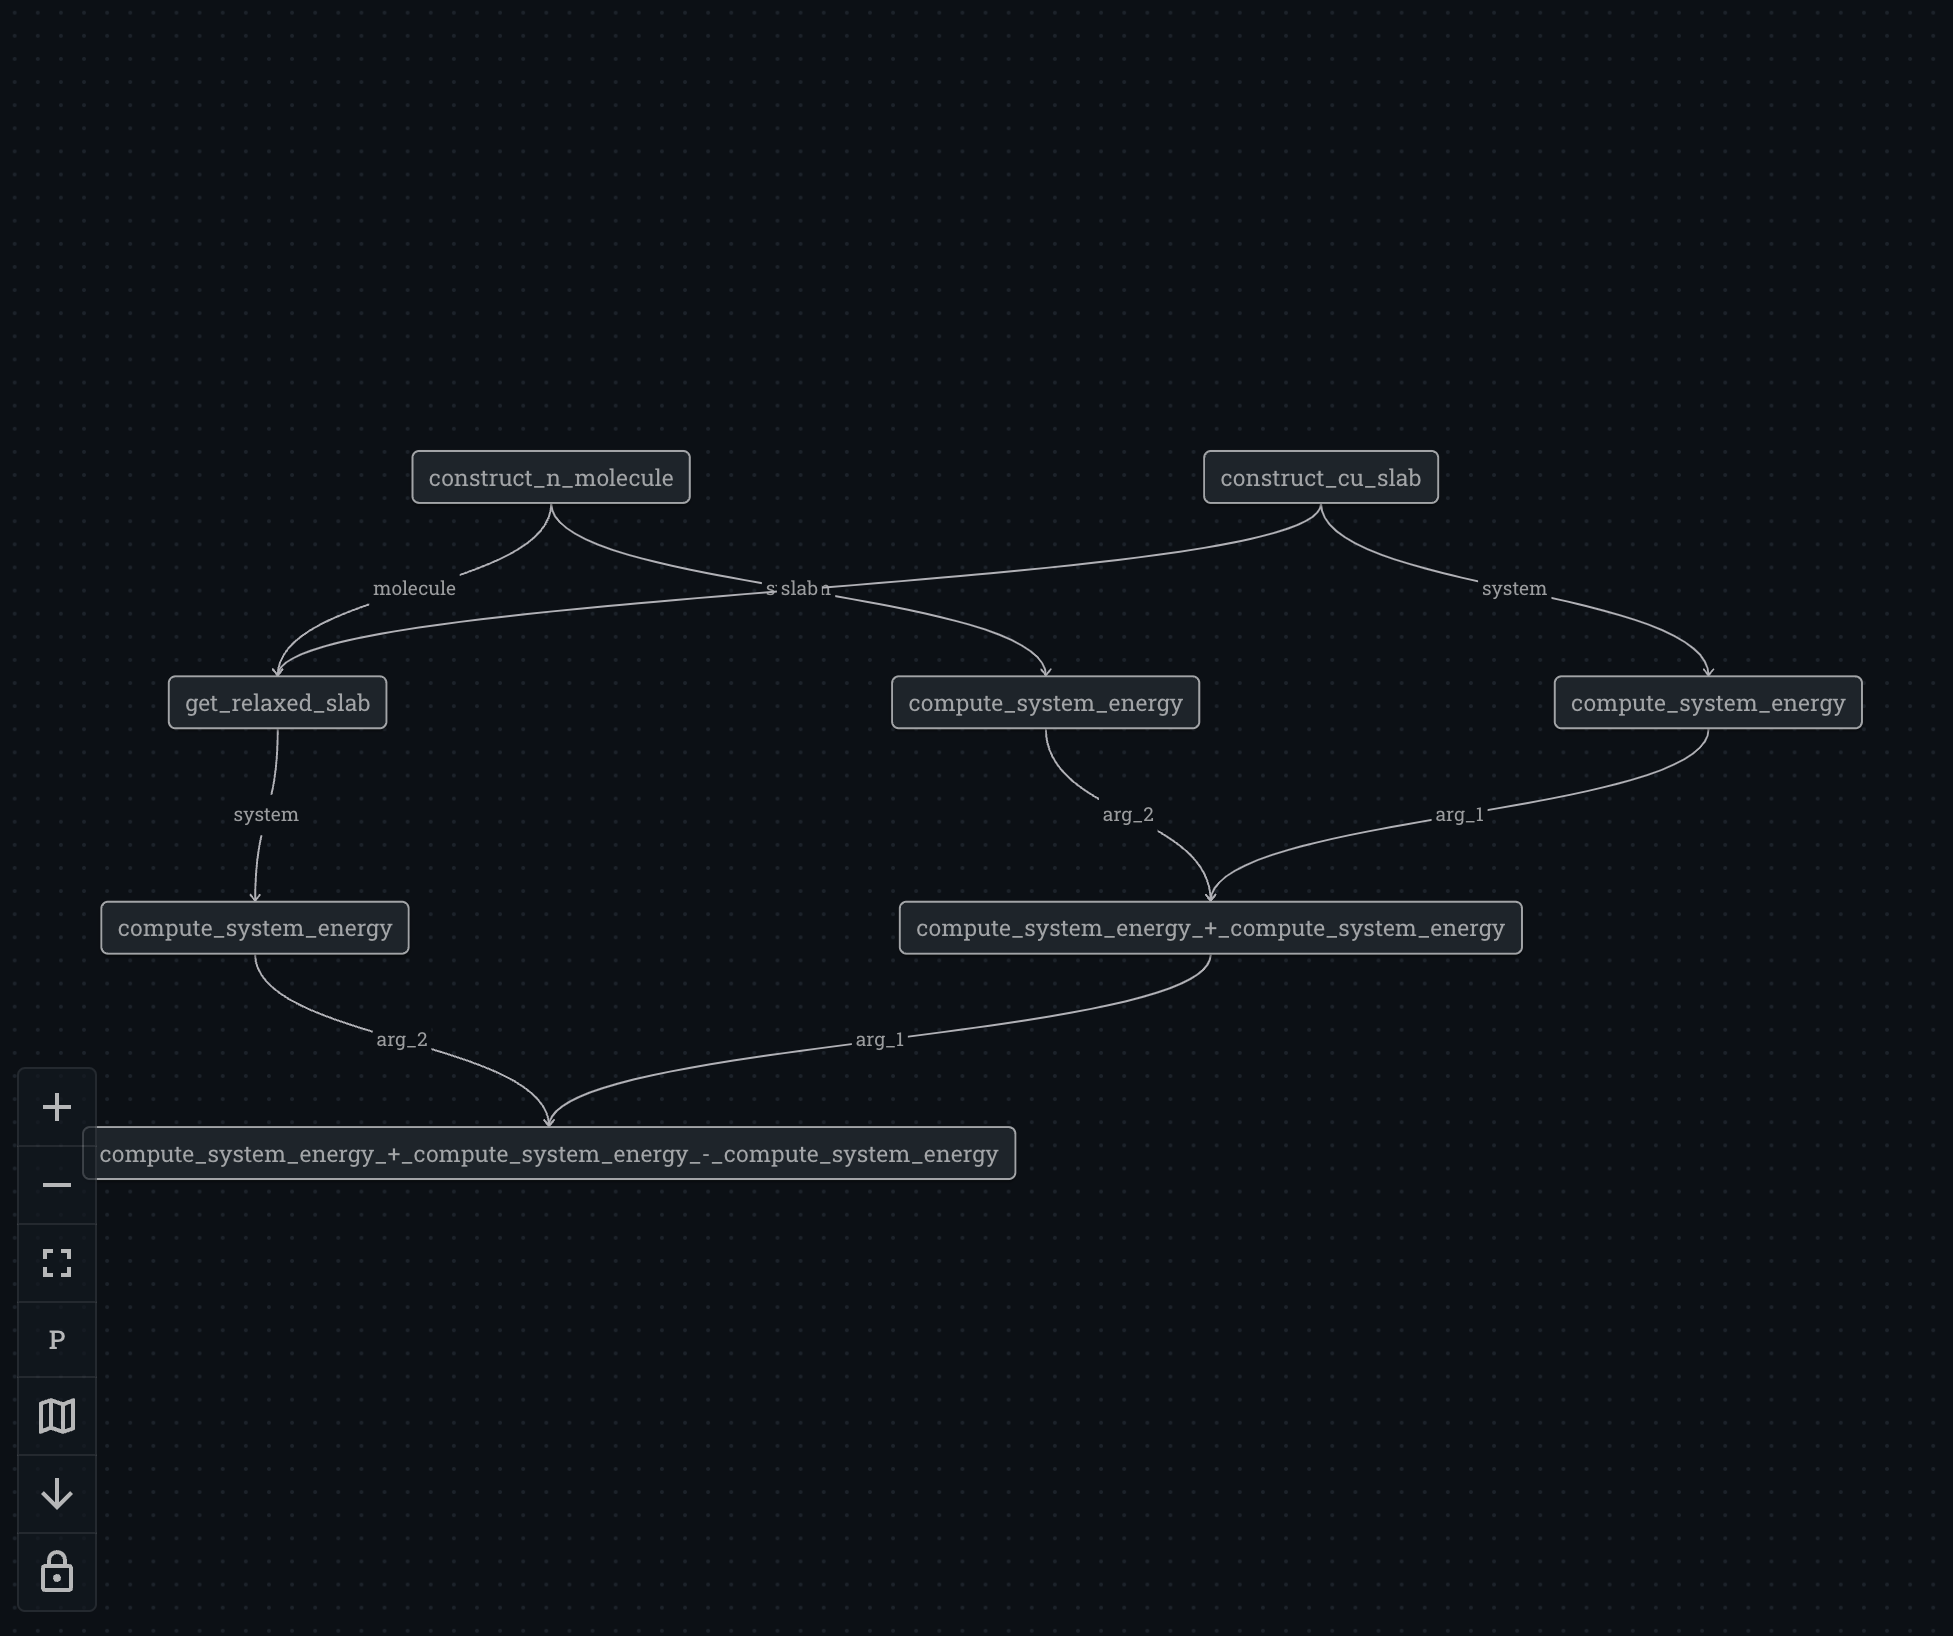

In [7]:
from IPython import display
display.Image("graphs/compute_energy.png")

Next, we send off the workflow for execution via the `dispatch` method and by passing the input parameters. This method submits the job to the dispatcher server which then sends the subtasks to the appropriate executors. 

In [8]:
dispatch_id = ct.dispatch(compute_energy)(initial_height=3, distance=1.10)


After the workflow has been dispatched, we can now query the result using [ct.get_result](../../api/api.rst#covalent.get_result). Specifying the `wait` parameter to `True` will ensure that the result is returned only once all the computations have been completed. Lastly, the parameter `results_dir` needs to be specified if a non-default value (by default `results_dir=./results`) had been set in the lattice decorator.  

In [9]:
result = ct.get_result(dispatch_id=dispatch_id, wait=True)

print(
    f"Computation status = {result.status}\nEnergy of slab + nitrogen system = {result.result:.4f}"
)


Computation status = COMPLETED
Energy of slab + nitrogen system = 0.7205


.. tip:: For longer running jobs, we might want to set `wait` parameter to `False`, in which case, the result object is retrieved before the computations have finished executing. This allows us to query the **_status_** (and other relevant information such as execution start/end time) of each subtask using the `get_node_result(node_id)` method. 

Furthermore, we can query the **_result_** of each subtask via `get_all_node_outputs`. The result of each node can be accessed with the key in the format 'subtask_name(node_id)'. The node_id can be found by examining the workflow visualization.

In [10]:
import pprint

pp = pprint.PrettyPrinter(indent=1)

pp.pprint(result.get_all_node_outputs())


{':parameter:(4, 4, 2)(4)': (4, 4, 2),
 ':parameter:1.1(1)': 1.1,
 ':parameter:10.0(5)': 10.0,
 ':parameter:3(8)': 3,
 'compute_system_energy(2)': 0.44034357303561467,
 'compute_system_energy(6)': 11.905341687099202,
 'compute_system_energy(9)': 11.625212574435649,
 'compute_system_energy_+_compute_system_energy(10)': 12.345685260134816,
 'compute_system_energy_+_compute_system_energy_-_compute_system_energy(11)': 0.7204726856991677,
 'construct_cu_slab(3)': Atoms(symbols='Cu32N2', pbc=[True, True, False], cell=[[10.210621920333747, 0.0, 0.0], [5.105310960166873, 8.842657971447272, 0.0], [0.0, 0.0, 22.08423447177455]], tags=..., constraint=FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]), calculator=EMT(...)),
 'construct_n_molecule(0)': Atoms(symbols='N2', pbc=False, calculator=EMT(...)),
 'get_relaxed_slab(7)': Atoms(symbols='Cu32N2', pbc=[True, True, False], cell=[[10.210621920333747, 0.0, 0.0], 

Further information on the subtask execution can be queried using the `node_id` param.

In [11]:
pp.pprint(result.get_node_result(node_id=0))


{'end_time': datetime.datetime(2022, 3, 15, 23, 20, 32, 222990, tzinfo=datetime.timezone.utc),
 'error': None,
 'node_id': 0,
 'node_name': 'construct_n_molecule(0)',
 'output': Atoms(symbols='N2', pbc=False, calculator=EMT(...)),
 'start_time': datetime.datetime(2022, 3, 15, 23, 20, 32, 193162, tzinfo=datetime.timezone.utc),
 'status': Status(STATUS='COMPLETED'),
 'stderr': '',
 'stdout': '',
 'sublattice_result': None}


## Making a new workflow based on (sub) workflows


Having constructed a workflow to optimize the height for a given nitrogen molecule spacing, $d$, we want to construct a workflow that optimizes the molecule spacing. Covalent allows us to construct workflows out of other workflows using the `ct.electron` function (shown below). Furthermore, Covalent automatically parallelizes the execution of each subworkflow.


In [12]:
import numpy as np

optimize_height = ct.electron(compute_energy)


@ct.lattice
def vary_distance(distance):
    result = []
    for i in distance:
        result.append(optimize_height(initial_height=3, distance=i))
    return result


Alternatively, instead of constructing the sublattice via `optimize_height = ct.electron(compute_energy)`, we could also have used the `ct.electron` decorator on top of the `ct.lattice` decorator when `compute_energy` was defined (syntax shown below).

```
@ct.electron
@ct.lattice
def compute_energy(**params):
    ...
```

We can visualize the new workflow using the syntax shown previously.

In [17]:
import numpy as np

distance = np.linspace(1, 1.5, 3)

vary_distance.draw(distance=np.round(distance, 2))


This graph will look something like this:

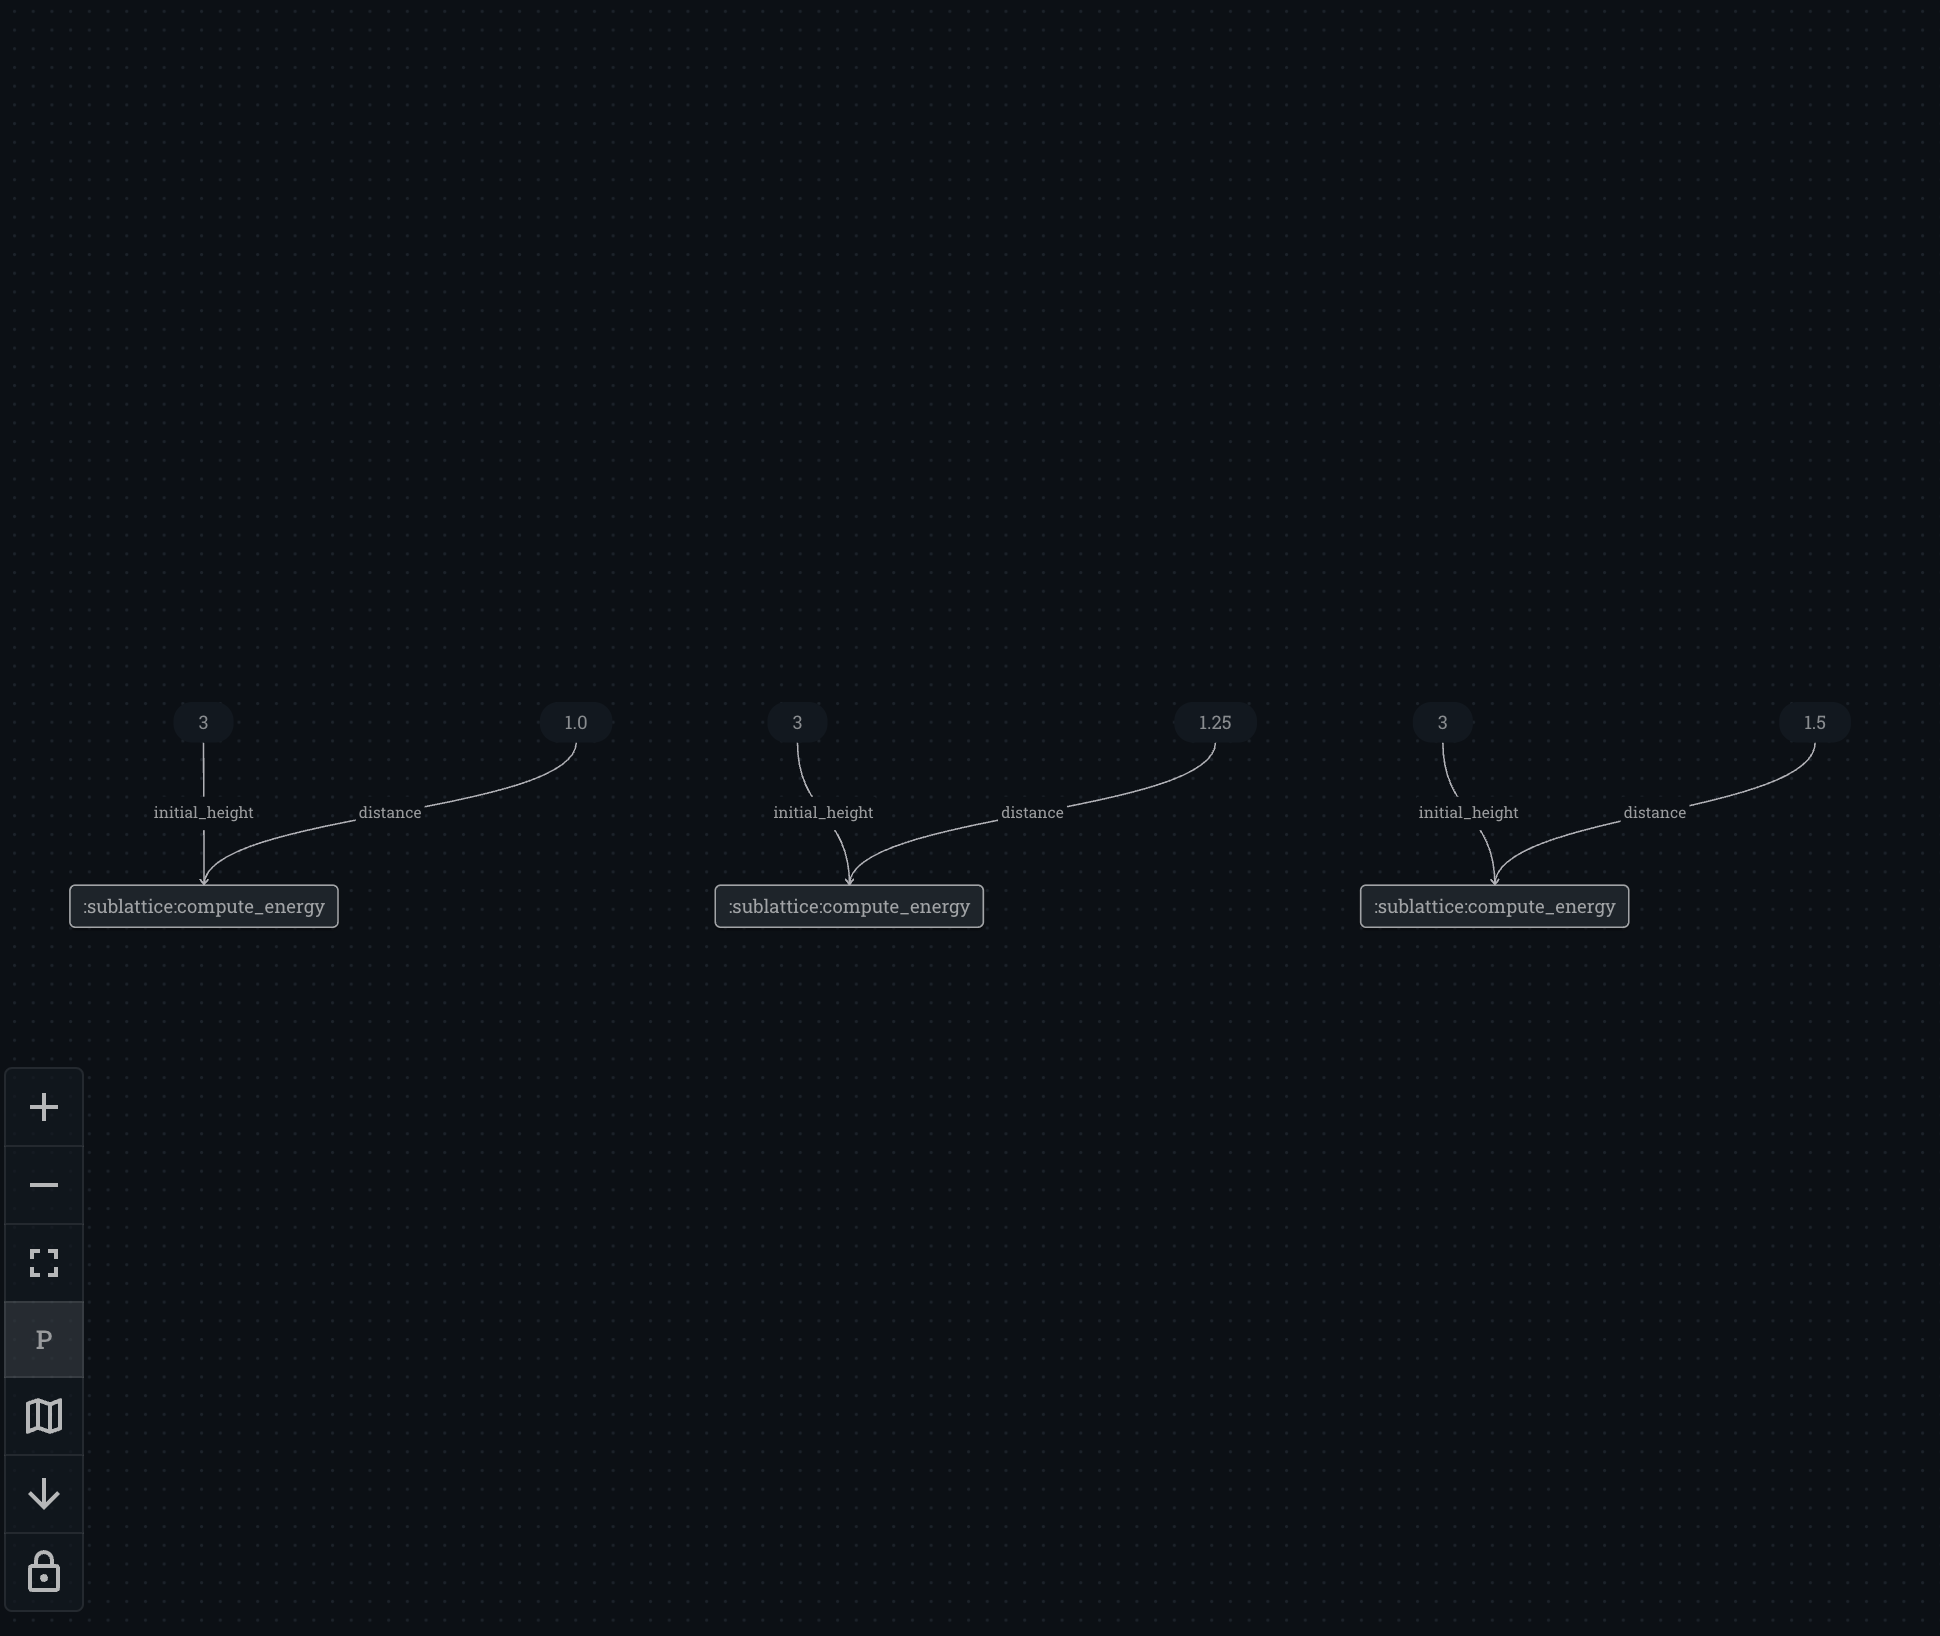

In [18]:
display.Image("graphs/vary_distance.png")

In [14]:
seps = 7
distance = np.linspace(1, 1.5, seps)
dispatch_id = ct.dispatch(vary_distance)(distance=distance)


One thing to note here is the value of `seps` which are the number of separations to be there in `np.linspace`. This directly translates to the number of sublattices that will be created and hence its dependent on the hardware upon which this experiment is being run. Thus, if you see that the experiment is taking a long time and is not finishing, then try again after lowering the value of `seps`.

In [15]:
result = ct.get_result(dispatch_id, wait=True)
print(result.status)


COMPLETED


Lastly, we plot the workflow computation results of the system energy as a function of the nitrogen molecule spacing after performing structural relaxation of the copper slab and nitrogen molecule system.

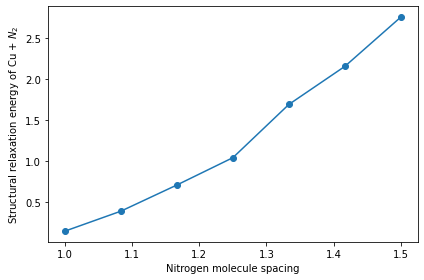

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), facecolor="w")
ax.plot(distance, result.result, marker="o")
ax.set_xlabel("Nitrogen molecule spacing")
ax.set_ylabel("Structural relaxation energy of Cu + ${N}_2$")
plt.tight_layout()
plt.show()


# Summary

In this tutorial, we saw how to translate a computational simulation problem into a workflow comprised of subtasks using the `covalent` library with the `electron` and `lattice` decorator. The primary benefits of *covalent* are as follows:

1. When lattices are executed, all the parallelizable sub-lattices (constructed via both electron and lattice decorator) are automatically executed in parallel
2. Nested workflows can be constructed very easily making this a versatile tool for high performance computing. 
3. Lastly, covalent handles the serialization / deserialization of the workflows as the jobs are submitted to the server. 